#### Imports

In [1]:
import numpy as np
import mdtraj as md
import os

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

#### Read works from the following relative paths

```
complex_1_steps/new.works.npy
complex_1_steps/old.works.npy
complex_500_steps/new.works.npy
complex_500_steps/old.works.npy
solvent_1_steps/new.works.npy
solvent_1_steps/old.works.npy
solvent_500_steps/new.works.npy
solvent_500_steps/old.works.npy
```

and save the results in a dictionary

In [2]:
works_dict = {}
paths = []
for phase in ['solvent', 'complex']:
    for side in ['new', 'old']:
        for steps in [1, 500]:
            try:
                path = f"{phase}_{steps}_steps/{side}.works.npy"
                paths.append(path)
                detail = np.load(path, allow_pickle=True)
                works_dict[f'{phase}.{steps}.{side}'] = detail.item()
            except Exception as e:
                print(e)

[Errno 2] No such file or directory: 'solvent_1_steps/old.works.npy'


In [3]:
for path in sorted(paths):
    print(path)

complex_1_steps/new.works.npy
complex_1_steps/old.works.npy
complex_500_steps/new.works.npy
complex_500_steps/old.works.npy
solvent_1_steps/new.works.npy
solvent_1_steps/old.works.npy
solvent_500_steps/new.works.npy
solvent_500_steps/old.works.npy


#### What keys does this dictionary have?

In [4]:
works_dict.keys()

dict_keys(['solvent.1.new', 'solvent.500.new', 'solvent.500.old', 'complex.1.new', 'complex.500.new', 'complex.1.old', 'complex.500.old'])

In [5]:
works_dict['solvent.500.old'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

#### What do these work trajectories look like?

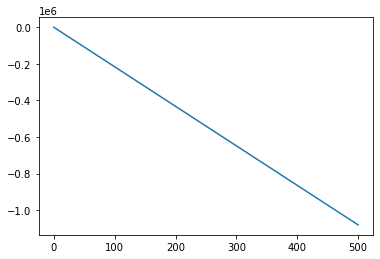

In [6]:
plt.plot(works_dict['solvent.500.old'][0])

In [7]:
type(works_dict['solvent.500.old'][0])

list

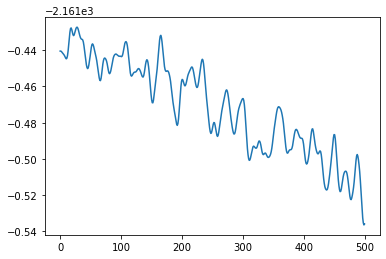

In [8]:
plt.plot(np.diff(works_dict['solvent.500.old'][0]))

#### Let's replace the inner nested dictionaries with a dictionary whose values are arrays

`works_dict` has `{'solvent.500.old' : work_dict}` pairs. Let's unpack each `work_dict`.

In [9]:
def work_array_from_inner_work_dict(inner_work_dict):
    """assume work_dict has { key : accumulated_work_array } pairs
    
    assume each accumulated_work_array has the same length
    
    return an array of shape (len(work_dict), len(accumulated_work_array))
    """
    
    keys = sorted(list(inner_work_dict.keys()))
    work_array = np.zeros((len(keys), len(inner_work_dict[keys[0]])))
    for i, key in enumerate(keys):
        work_array[i] = np.array(inner_work_dict[key])
    return work_array

In [10]:
work_arrays = dict()
for key in works_dict:
    work_arrays[key] = work_array_from_inner_work_dict(works_dict[key])

    print('{}:\n\t{}'.format(key, work_arrays[key].shape))

solvent.1.new:
	(100, 2)
solvent.500.new:
	(100, 501)
solvent.500.old:
	(100, 501)
complex.1.new:
	(100, 2)
complex.500.new:
	(100, 501)
complex.1.old:
	(100, 2)
complex.500.old:
	(100, 501)


#### Let's look at work standard deviations

In [11]:
def final_work_stddev(work_array):
    return np.std(work_array, 0)[-1]

for key in work_arrays:
    print('{}:\n\t{:.4f}'.format(key, final_work_stddev(work_arrays[key])))

solvent.1.new:
	8.2076
solvent.500.new:
	3.4142
solvent.500.old:
	3.3491
complex.1.new:
	8.4938
complex.500.new:
	2.4660
complex.1.old:
	7.9462
complex.500.old:
	1.8952


#### Let's look at the work stddev time-series

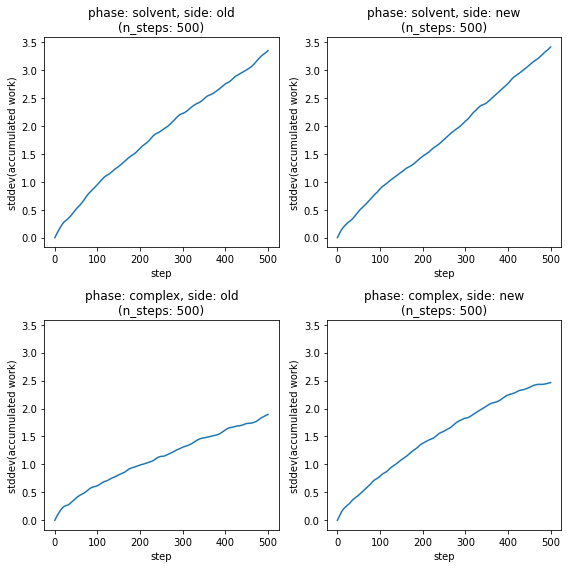

In [12]:
ind = 1; ax = None
n_steps = 500
plt.figure(figsize=(8,8))
for phase in ['solvent', 'complex']:
    for side in ['old', 'new']:
        key = f'{phase}.{n_steps}.{side}'
        w_stddev = work_arrays[key].std(0)
        
        ax = plt.subplot(2,2,ind, sharey=ax)
        ind += 1

        plt.plot(w_stddev)
        title = f'phase: {phase}, side: {side}\n(n_steps: {n_steps})'
        plt.title(title)
        plt.xlabel('step')
        plt.ylabel('stddev(accumulated work)')
plt.tight_layout()

#### Err, all on one plot

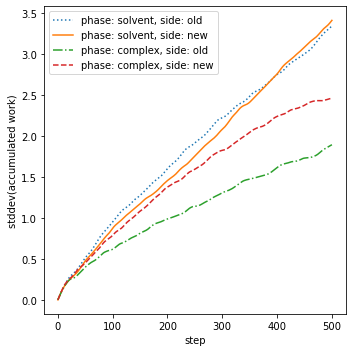

In [13]:
plt.figure(figsize=(5,5))

phases = ['solvent', 'complex']
sides = ['old', 'new']
markers = {'solvent': 'o', 'complex': 'triangle'}
linestyles =  {
    ('solvent', 'new'): 'solid',
    ('complex', 'new'): 'dashed',
    ('solvent', 'old'): 'dotted',
    ('complex', 'old'): 'dashdot',
}


for phase in phases:
    for side in sides:
        key = f'{phase}.{n_steps}.{side}'
        w_stddev = work_arrays[key].std(0)
        
        label = f'phase: {phase}, side: {side}'
        plt.plot(w_stddev, label=label, linestyle=linestyles[(phase, side)])

plt.xlabel('step')
plt.ylabel('stddev(accumulated work)')
plt.legend()
plt.tight_layout()

#### Histograms of final works

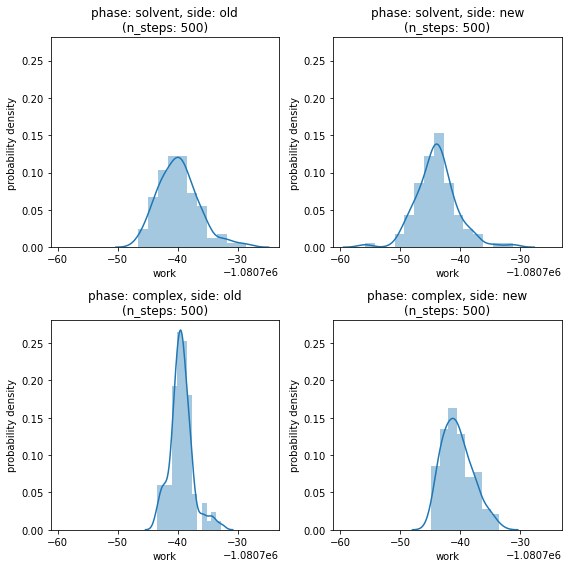

In [14]:
ind = 1; ax = None
n_steps = 500
plt.figure(figsize=(8,8))

dfs = {}

for phase in ['solvent', 'complex']:
    for side in ['old', 'new']:
        # extract final works
        key = f'{phase}.{n_steps}.{side}'
        final_works = work_arrays[key][:,-1]
        
        # set up axes, in particular sharing x-axis limits with other subplots
        ax = plt.subplot(2,2,ind, sharex=ax, sharey=ax)
        ind += 1

        # plot histogram and kde
        sns.distplot(final_works)
        
        
        title = f'phase: {phase}, side: {side}\n(n_steps: {n_steps})'
        plt.title(title)
        plt.xlabel('work')
        plt.ylabel('probability density')
        
        
        ## add a textbox for EXP estimates
        #from pymbar import EXP
        #df, ddf = EXP(final_works)
        #dfs[key] = df
        #textstr='EXP(w) : {:.3f}'.format(df) + r'$\pm$' + '{:.3f}'.format(ddf)
        #textbox_props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)
        #ax.text(
        #    0.05, 0.95, textstr,
        #    transform=ax.transAxes, fontsize=10,
        #    verticalalignment='top', bbox=textbox_props
        #)
plt.tight_layout()

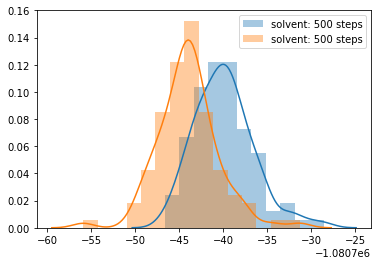

In [15]:
#sns.distplot([val[-1] for val in works_dict['solvent.1.old'].values()], label = f'solvent: instantaneous')
sns.distplot([val[-1] for val in works_dict['solvent.500.old'].values()], label = f'solvent: 500 steps')
sns.distplot([val[-1] for val in works_dict['solvent.500.new'].values()], label = f'solvent: 500 steps')
plt.legend()

#### Let's compare with corresponding instantaneous work distribution for each condition

'solvent.1.old'
had a problem with solvent.1.old


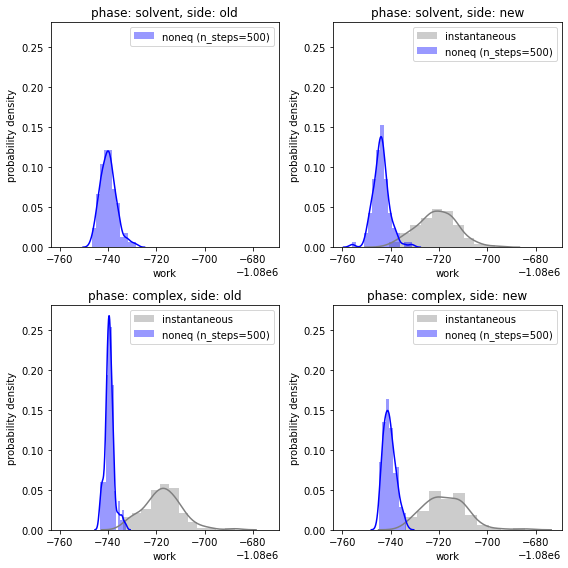

In [16]:
ind = 1; ax = None
n_steps = 500
plt.figure(figsize=(8,8))

inst_color = 'grey'
noneq_color = 'blue'

for phase in ['solvent', 'complex']:
    for side in ['old', 'new']:
        ax = plt.subplot(2,2,ind, sharex=ax, sharey=ax)
        ind += 1
        
        inst_key = f'{phase}.1.{side}'
        noneq_key = f'{phase}.{n_steps}.{side}'
        
        # hmm, missing one
        try:
            inst_works = work_arrays[inst_key][:,-1]
            sns.distplot(inst_works, label='instantaneous', color=inst_color)
        except Exception as e:
            print(e)
            print(f'had a problem with {inst_key}')
        
        noneq_works = work_arrays[noneq_key][:,-1]
        sns.distplot(noneq_works, label=f'noneq (n_steps={n_steps})', color=noneq_color)
        
        title = f'phase: {phase}, side: {side}'
        
        plt.legend()
        plt.title(title)
        plt.xlabel('work')
        plt.ylabel('probability density')
plt.tight_layout()

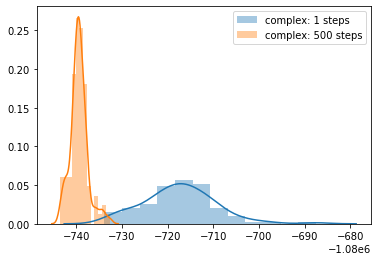

In [17]:
#sns.distplot([val[-1] for val in works_dict['complex.1.old'].values()], label = 'complex: instantaneous')
sns.distplot([val[-1] for val in works_dict['complex.1.old'].values()], label = 'complex: 1 steps')
sns.distplot([val[-1] for val in works_dict['complex.500.old'].values()], label = 'complex: 500 steps')
plt.legend()

#### Computing EXP and BAR estimates for each leg

#### Computing endpoint correction

i am going to spell out how the free energy correction should be done. 
We know that the relative free energy of 'ligXtoY' is measured as dg_X - dg_Y; 
we also know that RT = 0.593 kcal/mol at 298K; <br>
first, let's plot the perses vs experimental results

In [18]:
perses_dgs = np.load('perses_calc_dgs.npy', allow_pickle=True).item()
experimental_dgs = np.load('exp_calc_dgs.npy', allow_pickle=True).item()

In [19]:
keys = perses_dgs.keys()
perses, calcs, perses_error = [], [], []
for key in keys:
    perses.append(perses_dgs[key][0])
    perses_error.append(perses_dgs[key][1])
    calcs.append(experimental_dgs[key])

Text(0, 0.5, '$\\Delta G_{calculation, MM}$ $[kT]$')

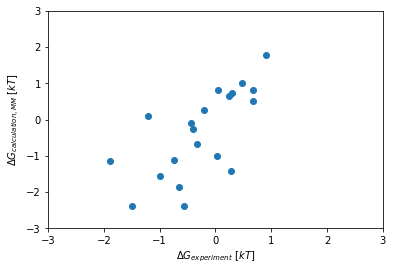

In [20]:
plt.scatter(calcs, perses)
slope, intercept, rval, pval, stderr = linregress(calcs, perses)
space = np.linspace(min(calcs), max(calcs), 100)
#plt.plot(space, space*slope + intercept)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel('$\Delta G_{experiment}$ $[kT]$')
plt.ylabel('$\Delta G_{calculation, MM}$ $[kT]$')

since we have $\Delta G_{MM} = \Delta G_{1, MM} - \Delta G_{2, MM}$, we can say that $\Delta G_{1, ANI} - \Delta G_{2, ANI} =  \Delta G_{MM}  + \left(  \Delta G_{complex, old} - \Delta G_{solvent, old}\right) - \left(  \Delta G_{complex, new} - \Delta G_{solvent, new} \right)$

In [21]:
from pymbar import EXP
dg_complex_old, ddg_complex_old = EXP(np.array([val[-1] for val in works_dict['complex.500.old'].values()]))
dg_complex_new, ddg_complex_new = EXP(np.array([val[-1] for val in works_dict['complex.500.new'].values()]))
dg_solvent_old, ddg_solvent_old = EXP(np.array([val[-1] for val in works_dict['solvent.500.old'].values()]))
dg_solvent_new, ddg_solvent_new = EXP(np.array([val[-1] for val in works_dict['solvent.500.new'].values()]))

In [22]:
ddg_complex_old

0.22065025489998402

In [23]:
ddg_solvent_old

0.35163691664713687

In [24]:
dg_complex_new -dg_complex_old

-1.48051657830365

In [25]:
(dg_complex_old - dg_solvent_old)/0.593

4.044486422556599

In [26]:
(dg_complex_new - dg_solvent_new)/0.593

15.071674821345516

In [27]:
binding_dg = perses_dgs[(0,2)][0]
ani_binding_dg = binding_dg + (dg_complex_old - dg_solvent_old)/0.593 - (dg_complex_new - dg_solvent_new)/0.593

In [28]:
ani_binding_dg

-12.035852260386434

In [29]:
ani_error = np.sqrt(perses_dgs[(0,2)][1]**2 + (ddg_solvent_old/0.593)**2 + (ddg_solvent_new/0.593)**2 + (ddg_complex_old/0.593)**2 + (ddg_complex_new/0.593)**2)

In [30]:
ani_error

1.8222523448746186

In [31]:
experimental_dgs[(0,2)]

0.028821999999999903

todo:
1. check ani forces
2. check thermocycle and free energy correction